In [1]:


# 9. 저장된 토크나이저 불러오기
print("\nLoading saved tokenizer...")
loaded_tokenizer = Tokenizer.from_file("./bpe_tokenizer/tokenizer.json")

# 10. 불러온 토크나이저로 테스트
print("\nTesting loaded tokenizer:")
text = "hello world"
encoded_loaded = loaded_tokenizer.encode(text)
print("Input text:", text)
print("Token IDs:", encoded_loaded.ids)
print("Tokens:", encoded_loaded.tokens)

# 11. 디코딩 테스트
decoded = loaded_tokenizer.decode(encoded_loaded.ids)
decoded = decoded.replace("Ġ", " ").strip()
print("Decoded text:", decoded)


Loading saved tokenizer...


NameError: name 'Tokenizer' is not defined

In [ ]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, BatchSampler
import config
from load_data import prepare_data
from dataloader import TranslationDataset, SequenceSampler, collate_fn
from model import Transformer
from torch.optim.lr_scheduler import LambdaLR
import math
import torch.optim as optim
from utils import lr_lambda, load_checkpoint
import json
from tqdm import tqdm  # tqdm 라이브러리 임포트


torch.manual_seed(config.seed)
torch.cuda.manual_seed_all(config.seed)


def evaluation(model, dev_dataloader,criterion):
    dev_loss = 0.0
    for dev_batch in dev_dataloader:
        source_sentence, target_sentence, lengths = dev_batch
        
        source_sentence = source_sentence.to(config.device)
        target_sentence = target_sentence.to(config.device)
        
        tgt_sentence = target_sentence[:,:-1]

        predict = model(source_sentence,tgt_sentence)
        
        loss = criterion(predict.view(-1,predict.size(-1)),target_sentence[:,1:].contiguous().view(-1))
        
        dev_loss += loss.item()
        
    dev_loss /= len(dev_dataloader)
    
    perplexity = torch.exp(torch.tensor(dev_loss))  # 구간 Perplexity 계산
    test_ppl = perplexity.item()

    return dev_loss, test_ppl



def training(model, train_dataloader,dev_dataloader, criterion, optimizer,scheduler,start_step,train_losses, train_ppls, dev_losses, dev_ppls, train_seq_sampler):

    step = start_step

    interval_loss = 0.0  # 특정 구간(예: 5000 스텝) 동안의 손실 누적
    interval_steps = 0   # 특정 구간의 스텝 수
    # tqdm 추가
    progress_bar = tqdm(total=config.total_steps, initial=step, desc="Training Progress", unit="step")
    
    while step <= config.total_steps:

        model.train()
        for train_batch in train_dataloader:
            source_sentence, target_sentence, lengths = train_batch

            source_sentence = source_sentence.to(config.device)
            target_sentence = target_sentence.to(config.device)
            
            tgt_sentence = target_sentence[:,:-1]

            predict = model(source_sentence,tgt_sentence)
            
            
            loss = criterion(predict.view(-1,predict.size(-1)),target_sentence[:,1:].contiguous().view(-1))
            
            interval_loss += loss.item()
            interval_steps += 1
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            
            train_avg_loss = interval_loss / interval_steps  # 구간 평균 손실
            perplexity = torch.exp(torch.tensor(train_avg_loss))  # 구간 Perplexity 계산
            train_avg_ppl = perplexity.item()
            
            # tqdm 업데이트
            progress_bar.update(1)

            # 일정 step마다 로그 출력 및 Perplexity 계산
            if step % 5000 == 0 and step > 0:
                with torch.no_grad():
                    model.eval()
                    dev_avg_loss, dev_avg_ppl = evaluation(model,dev_dataloader,criterion)
                model.train()
                
                print(f"Step {step}: Loss (train/dev) = {train_avg_loss:.4f}/{dev_avg_loss:.4f}, Perplexity (train/dev) = {train_avg_ppl:.4f}/{dev_avg_ppl:.4f}")

                train_losses.append(train_avg_loss)
                train_ppls.append(train_avg_ppl) 
                dev_losses.append(dev_avg_loss)
                dev_ppls.append(dev_avg_ppl) 
                
                # 구간 손실 및 스텝 초기화
                interval_loss = 0.0
                interval_steps = 0
                
            if step % 20000 == 0 and step > 0:       
                save_path = config.best_loss_model_path + f'{step}_checkpoint.pth'
                torch.save({
                    'step': step,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'train_sampler_state': train_seq_sampler.state_dict(),  # Sampler 상태 저장
                    'train_losses': train_losses,
                    'train_ppls': train_ppls,
                    'dev_losses': dev_losses,
                    'dev_ppls': dev_ppls
                }, save_path)
                
                print(f"{step} 번째 step의 체크포인트를 저장합니다.")
                
                # 리스트를 딕셔너리로 묶기
                results = {
                    'train_losses': train_losses,
                    'train_ppls': train_ppls,
                    'dev_losses': dev_losses,
                    'dev_ppls': dev_ppls
                }
                # results를 JSON 형식으로 파일에 저장
                with open(f'loss_result/{step}_step_results.txt', 'w') as f:
                    json.dump(results, f)
                
            step += 1
    progress_bar.close()



def main():
    
    # Data load
    train_pairs, tokenizer = prepare_data(config.path_ , config.token_path_, 'train', config.max_sentence_len)
    dev_pairs, tokenizer = prepare_data(config.path_ , config.token_path_, 'dev', config.max_sentence_len)

    # Define Dataset object
    train_dataset = TranslationDataset(train_pairs)
    dev_dataset = TranslationDataset(dev_pairs)
    
    # Load Model
    model = Transformer(config.vocab_size, config.embedding_dimension,config.hidden_dimension,config.n_head,config.n_layers,
                    config.h_ff, config.dropout_rate, config.device)
    model.to(config.device)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), betas=(config.beta_1,config.beta_2), eps=config.eps)
    # LambdaLR Scheduler & Label Smoothig Cross Entropy Loss
    scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
    criterion = nn.CrossEntropyLoss(label_smoothing = config.label_smoothing_rate, ignore_index = config.PAD)

    
    # Define DataLoader
    train_seq_sampler = SequenceSampler(train_dataset)
    
    # Checkpoint load
    start_step = 0
    train_losses, train_ppls, dev_losses, dev_ppls = [], [], [], []
    checkpoint_path = config.resume_checkpoint_path
    if checkpoint_path is not None:
        start_step, train_losses, train_ppls, dev_losses, dev_ppls = load_checkpoint(
            checkpoint_path, model, optimizer, scheduler,train_seq_sampler
        )

    train_batch_sp = BatchSampler(train_seq_sampler,batch_size = config.batch_size, drop_last=False)
    train_data_loader = DataLoader(train_dataset, batch_sampler= train_batch_sp, collate_fn=collate_fn)

    dev_seq_sampler = SequenceSampler(dev_dataset)
    dev_batch_sp = BatchSampler(dev_seq_sampler,batch_size = config.batch_size, drop_last=False)
    dev_data_loader = DataLoader(dev_dataset, batch_sampler= dev_batch_sp, collate_fn=collate_fn)

    training(model, train_data_loader, dev_data_loader, criterion, optimizer, scheduler,start_step,train_losses, train_ppls, dev_losses, dev_ppls,train_seq_sampler)

if __name__ == '__main__':
    
    main()


Loading saved tokenizer...

Loading saved tokenizer...
[0, 11776, 237, 1097, 374, 428, 14404, 76, 302, 250, 306, 250, 219, 7905, 588, 276, 7340, 204, 258, 387, 768, 806, 358, 468, 594, 340, 291, 251, 504, 426, 311, 1826, 893, 7845, 224, 258, 840, 590, 2426, 403, 28986, 405, 261, 11576, 64, 532, 457, 40, 573, 5056, 3170, 3639, 545, 212, 1]


!!!!!!!!!!!!!!!!!!! torch.Size([64, 48])
torch.Size([64, 47])


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [2]:
a =[291, 306, 142, 379, 145, 252, 292, 132, 221, 62, 383, 90, 50, 68, 124, 60, 373, 113, 247, 29, 293, 309, 39, 45, 63, 250, 86, 153, 259, 345, 125, 11, 33, 168, 176, 23, 41, 42, 185, 202, 76, 134, 308, 374, 382, 22, 40, 61, 184, 65, 97, 100, 102, 103, 363, 91, 116, 201, 367, 384, 149, 151, 321, 336, 31, 34, 75, 128, 131, 140, 188, 204, 258, 277, 30, 67, 139, 192, 194, 218, 285, 294, 361, 0, 80, 120, 10, 46, 66, 79, 240, 37, 77, 141, 150, 257, 20, 88, 186, 205, 279, 96, 122, 298, 16, 95, 121, 249, 82, 87, 94, 214, 242, 270, 339, 392, 18, 47, 54, 126, 183, 191, 237, 278, 286, 295, 332, 342, 376, 27, 43, 99, 174, 220, 256, 264, 312, 350, 53, 56, 57, 83, 130, 211, 243, 365, 14, 92, 197, 261, 357, 396, 74, 206, 236, 251, 305, 340, 398, 21, 52, 55, 115, 136, 213, 246, 300, 362, 378, 397, 73, 108, 161, 228, 263, 307, 341, 13, 69, 72, 109, 137, 154, 165, 203, 232, 275, 280, 288, 297, 301, 303, 399, 51, 59, 64, 98, 101, 189, 209, 283, 313, 343, 344, 352, 369, 5, 12, 17, 19, 38, 48, 144, 155, 156, 160, 212, 225, 226, 290, 299, 316, 347, 348, 356, 375, 9, 110, 163, 166, 167, 230, 241, 244, 262, 310, 323, 334, 354, 368, 381, 2, 24, 25, 71, 104, 162, 177, 260, 269, 372, 1, 8, 111, 133, 152, 207, 234, 238, 253, 267, 327, 333, 351, 106, 107, 119, 123, 135, 175, 182, 190, 193, 233, 254, 338, 70, 85, 89, 138, 164, 200, 231, 271, 335, 364, 15, 78, 112, 127, 208, 272, 273, 289, 302, 304, 320, 325, 337, 349, 353, 355, 359, 394, 28, 32, 35, 58, 81, 93, 105, 143, 158, 170, 181, 196, 219, 222, 227, 284, 311, 360, 380, 385, 117, 147, 148, 169, 215, 223, 224, 229, 235, 274, 282, 322, 387, 6, 7, 36, 114, 118, 146, 159, 171, 173, 179, 217, 287, 296, 317, 328, 331, 366, 390, 393, 44, 49, 129, 157, 172, 178, 187, 195, 198, 239, 265, 266, 276, 281, 324, 326, 329, 330, 371, 386, 388, 389, 395, 26, 199, 216, 268, 370, 84, 180, 210, 245, 248, 315, 319, 346, 3, 255, 314, 318, 358, 377, 391, 4]
len(a)

400

In [ ]:
def translate_with_encoder_decoder(model, src, max_len=50, start_token=config.START_TOKEN, end_token=config.END_TOKEN):
    """
    Transformer 모델의 encoder와 decoder를 직접 활용하여 번역 수행
    :param model: Transformer 모델
    :param src: 소스 문장 텐서
    :param max_len: 생성할 최대 길이
    :param start_token: 디코딩 시작 토큰
    :param end_token: 디코딩 종료 토큰
    """
    # 1. 인코더 실행
    enc_attn_mask = model.gen_att_mask(src, config.PAD)
    embed_src = model.embedding(src)
    pos_src = model.Positional_Embedding(embed_src, model.device).unsqueeze(0)
    enc_embed_input = model.dropout(embed_src + pos_src)
    encoder_output = model.transformer_encoder(enc_embed_input, enc_attn_mask)

    # 2. 디코더 준비
    tgt = torch.tensor([[start_token]], device=model.device)  # 디코더 입력 초기화 (시작 토큰)

    # 3. 반복적 디코딩
    for _ in range(max_len):
        dec_attn_mask = model.gen_att_mask(tgt, config.PAD)
        embed_tgt = model.embedding(tgt)
        pos_tgt = model.Positional_Embedding(embed_tgt, model.device).unsqueeze(0)
        dec_embed_input = model.dropout(embed_tgt + pos_tgt)

        decoder_output = model.transformer_decoder(encoder_output, dec_embed_input, dec_attn_mask)
        logits = model.fc_out(decoder_output[:, -1, :])  # 마지막 단어의 로짓
        predicted_token = torch.argmax(logits, dim=-1)  # 가장 높은 확률의 토큰 선택

        # 종료 조건 확인
        if predicted_token.item() == end_token:
            break

        # 디코더 입력 확장
        tgt = torch.cat([tgt, predicted_token.unsqueeze(0)], dim=1)

    return tgt.squeeze(0).tolist()

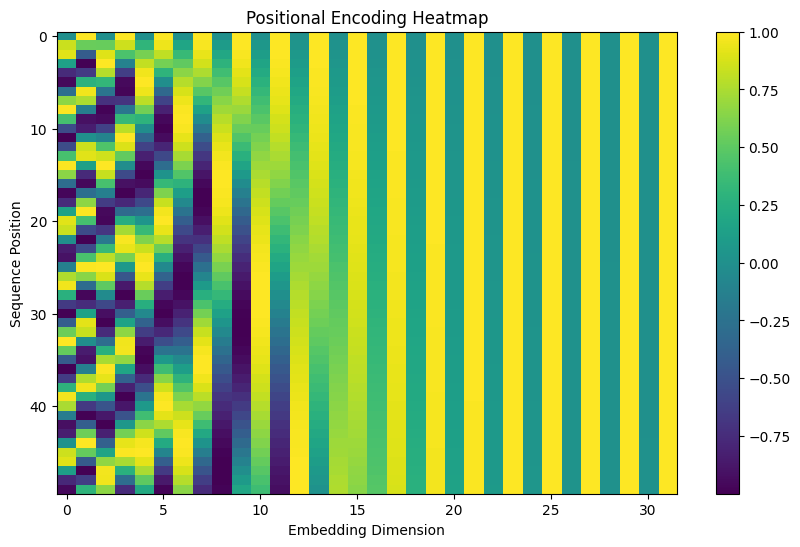

In [3]:
import torch
import matplotlib.pyplot as plt

def positional_embedding_example(seq_len, embed_dim, device='cpu'):
    pos = torch.arange(seq_len, device=device).unsqueeze(1)  # [seq_len, 1]
    i_ = torch.arange(embed_dim, device=device).unsqueeze(0)  # [1, embed_dim]
    si_ = torch.pow(10000.0, (2 * (i_ // 2)) / embed_dim)  # Scaling factors [1, embed_dim]

    pos_encoding = torch.zeros(seq_len, embed_dim, device=device)  # Initialize Positional Encoding [seq_len, embed_dim]
    pos_encoding[:, 0::2] = torch.sin(pos / (si_[:, 0::2]))  # Apply sin to even indices
    pos_encoding[:, 1::2] = torch.cos(pos / (si_[:, 1::2]))  # Apply cos to odd indices

    return pos_encoding

# Example Parameters
seq_len = 50  # Length of the sequence
embed_dim = 32  # Embedding dimension

# Generate Positional Encoding
device = 'cpu'
positional_encoding = positional_embedding_example(seq_len, embed_dim, device)

# Visualize the Positional Encoding as a Heatmap
plt.figure(figsize=(10, 6))
plt.imshow(positional_encoding.cpu().numpy(), aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Positional Encoding Heatmap")
plt.xlabel("Embedding Dimension")
plt.ylabel("Sequence Position")
plt.show()

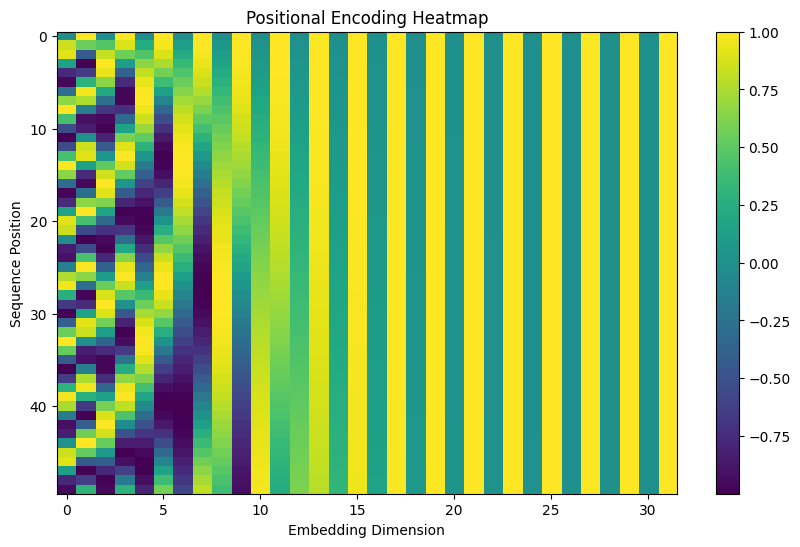

In [4]:
import torch
import matplotlib.pyplot as plt

def positional_embedding_example(seq_len, embed_dim, device='cpu'):
    pos = torch.arange(seq_len, device=device).unsqueeze(1)  # [seq_len, 1]
    i_ = torch.arange(embed_dim, device=device).unsqueeze(0)  # [1, embed_dim]
    si_ = torch.pow(100000.0, (2 * (i_ // 2)) / embed_dim)  # Scaling factors [1, embed_dim]

    pos_encoding = torch.zeros(seq_len, embed_dim, device=device)  # Initialize Positional Encoding [seq_len, embed_dim]
    pos_encoding[:, 0::2] = torch.sin(pos / (si_[:, 0::2]))  # Apply sin to even indices
    pos_encoding[:, 1::2] = torch.cos(pos / (si_[:, 1::2]))  # Apply cos to odd indices

    return pos_encoding

# Example Parameters
seq_len = 50  # Length of the sequence
embed_dim = 32  # Embedding dimension

# Generate Positional Encoding
device = 'cpu'
positional_encoding = positional_embedding_example(seq_len, embed_dim, device)

# Visualize the Positional Encoding as a Heatmap
plt.figure(figsize=(10, 6))
plt.imshow(positional_encoding.cpu().numpy(), aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Positional Encoding Heatmap")
plt.xlabel("Embedding Dimension")
plt.ylabel("Sequence Position")
plt.show()

In [1]:
    # def Positional_Embedding(self, embedding,device):
    #     #print(embedding.size()) # [batch, seq_len, embed_dim]
    #     seq_len = embedding.size(1)
    #     embed_dim = embedding.size(2)
        
    #     pos = torch.arange(seq_len,device = device).unsqueeze(1)
    #     i_ = torch.arange(embed_dim,device = device).unsqueeze(0)
        
    #     si_ = torch.pow(100000.0, (2*(i_//2))/embed_dim)
        
    #     pos_encoding = torch.zeros(seq_len,embed_dim,device = device)
    #     pos_encoding[:,0::2] = torch.sin(pos/(si_[:,0::2]))
    #     pos_encoding[:,1::2] = torch.cos(pos/(si_[:,1::2]))
        
    #     return pos_encoding